In [1]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from pykalman import KalmanFilter
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import entropy
from scipy.fft import rfft, rfftfreq
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [2]:
# ================================
# DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_Thermostat.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (32774, 6)

DATASET OVERVIEW
        date     time  current_temperature  thermostat_status  label  \
0  25-Apr-19  8:59:02            30.577325                  1      1   
1  25-Apr-19  8:59:06            29.187912                  1      1   
2  25-Apr-19  8:59:06            30.208893                  1      1   
3  25-Apr-19  8:59:06            27.731392                  1      1   
4  25-Apr-19  8:59:06            26.211462                  1      1   
5  25-Apr-19  8:59:07            30.496262                  1      1   
6  25-Apr-19  8:59:08            32.575755                  1      1   
7  25-Apr-19  8:59:08            28.928770                  1      1   
8  25-Apr-19  8:59:11            29.012420                  1      1   
9  25-Apr-19  8:59:11            30.013785                  1      1   

        type  
0  injection  
1  injection  
2  injection  
3  injection  
4  injection  
5  injection  
6  injection  
7  injection  


DATA EXPLORATION
Data Types:
date                    object
time                    object
current_temperature    float64
thermostat_status        int64
label                    int64
type                    object
dtype: object

Unique current temperature: [30.57732541 29.18791215 30.20889259 ... 26.01162765 30.09367188
 29.85261281]
Unique thermostat status: [1 0]
Attack type distribution:
type
normal        15000
injection      5000
backdoor       5000
password       5000
ransomware     2264
xss             449
scanning         61
Name: count, dtype: int64


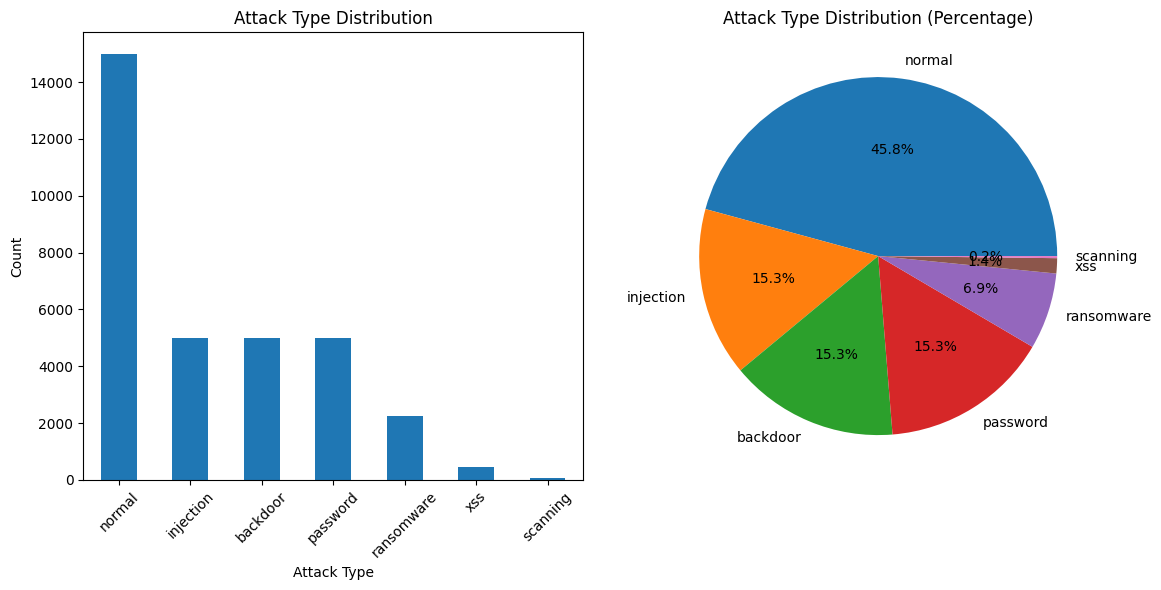

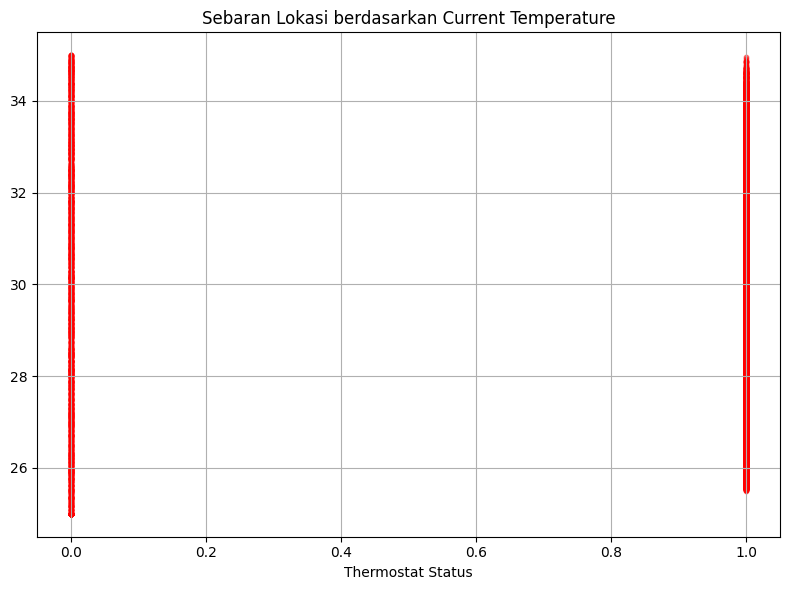

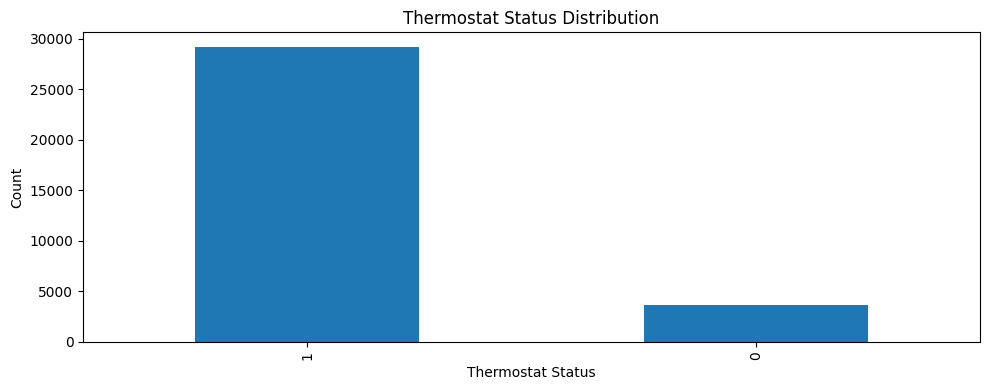

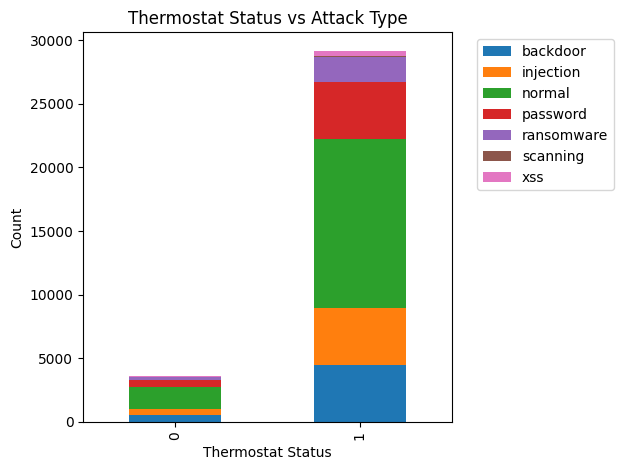

In [3]:
# ================================
# DATA EXPLORATION
# ================================

print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Check data types
print("Data Types:")
print(df.dtypes)

# Check unique values in categorical columns
print(f"\nUnique current temperature: {df['current_temperature'].unique()}")
print(f"Unique thermostat status: {df['thermostat_status'].unique()}")
print(f"Attack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

# Visualize attack type distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['thermostat_status'], df['current_temperature'],
            c='red', alpha=0.5, s=10)
plt.title('Sebaran Lokasi berdasarkan Current Temperature')
plt.xlabel('Thermostat Status')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'location_temperature_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

# Thermostat Status distribution
plt.figure(figsize=(10, 4))
df['thermostat_status'].value_counts().plot(kind='bar')
plt.title('Thermostat Status Distribution')
plt.xlabel('Thermostat Status')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'thermostat_status_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['thermostat_status'], df['type']).plot(kind='bar', stacked=True)
plt.title('Thermostat Status vs Attack Type')
plt.xlabel('Thermostat Status')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'thermostat_status_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Implementasi Kalman Filter
def apply_kalman_filter(signal_data):
    if hasattr(signal_data, 'values'):
        signal_array = signal_data.values
    else:
        signal_array = np.array(signal_data)
    observations = signal_array.reshape(-1, 1)
    kf = KalmanFilter(
        transition_matrices=np.array([[1, 1], [0, 1]]),
        observation_matrices=np.array([[1, 0]]),
        initial_state_mean=np.array([signal_array[0], 0]),
        initial_state_covariance=np.eye(2),
        observation_covariance=np.array([[1.0]]),
        transition_covariance=np.array([[0.1, 0], [0, 0.1]]),
        n_dim_state=2
    )
    kf_fitted = kf.em(observations, n_iter=10)
    state_means, _ = kf_fitted.smooth(observations)
    return state_means[:, 0]

In [5]:
df_filtered = df.copy()
# df_filtered['current_temperature'] = apply_kalman_filter(df['current_temperature'])

In [7]:
# ================================
# FEATURE ENGINEERING
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

df_processed = df_filtered.copy()

# Gabung datetime dan ekstrak komponen
df_processed['datetime'] = pd.to_datetime(df_processed['date'].str.strip() + ' ' + df_processed['time'].str.strip(),
                                format='%d-%b-%y %H:%M:%S', errors='coerce')
df_processed = df_processed.sort_values('datetime').reset_index(drop=True)
df_processed['group_id'] = df_processed['datetime'].dt.floor('T')  # per menit
df_processed['hour']        = df_processed['datetime'].dt.hour
df_processed['minute']      = df_processed['datetime'].dt.minute
df_processed['second']      = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend']  = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['hour_sin']    = np.sin(2*np.pi*df_processed['hour']/24)
df_processed['hour_cos']    = np.cos(2*np.pi*df_processed['hour']/24)
df_processed['min_sin']     = np.sin(2*np.pi*df_processed['minute']/60)
df_processed['min_cos']     = np.cos(2*np.pi*df_processed['minute']/60)

# Time diff
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds().fillna(0)

# Temperature Dynamics Features
# --------------------------------
win = 10  # Rolling window size

# Basic rolling stats
df_processed['temp_roll_mean'] = df_processed['current_temperature'].rolling(window=win, min_periods=1).mean()
df_processed['temp_roll_std'] = df_processed['current_temperature'].rolling(window=win, min_periods=1).std().fillna(0)
df_processed['temp_roll_range'] = (df_processed['current_temperature'].rolling(window=win, min_periods=1).max() - 
                                  df_processed['current_temperature'].rolling(window=win, min_periods=1).min())

# Rate of change
df_processed['temp_diff'] = df_processed['current_temperature'].diff().fillna(0)
df_processed['temp_velocity'] = df_processed['temp_diff'] / df_processed['time_diff'].replace(0, 1e-6)
df_processed['temp_acceleration'] = df_processed['temp_velocity'].diff().fillna(0) / df_processed['time_diff'].replace(0, 1e-6)

# Stability metrics
df_processed['temp_zscore'] = (df_processed['current_temperature'] - df_processed['temp_roll_mean']) / df_processed['temp_roll_std'].replace(0, 1e-6)
df_processed['is_temp_anomaly'] = (np.abs(df_processed['temp_zscore']) > 3).astype(int)

# Thermostat Behavior Features
# -------------------------------
# State changes
df_processed['thermostat_change'] = df_processed['thermostat_status'].diff().abs().fillna(0)
# Buat kelompok perubahan status
group_ids = (df_processed['thermostat_status'] != df_processed['thermostat_status'].shift(1)).cumsum()

# Hitung durasi total dari setiap status dalam satu grup
df_processed['thermostat_state_duration'] = group_ids.map(
    df_processed.groupby(group_ids)['time_diff'].cumsum()
)
# State statistics
df_processed['on_state_percentage'] = (df_processed['thermostat_status']
                                       .rolling(window=win, min_periods=1)
                                       .mean())

# Advanced Signal Processing Features
# --------------------------------------
from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy

def dominant_freq(arr, sr=1.0):
    if len(arr) < 3:  # Minimum samples for FFT
        return 0.0
    yf = np.abs(rfft(arr - np.mean(arr)))  # Remove DC component
    xf = rfftfreq(len(arr), d=1/sr)
    if len(yf) < 2:  # Handle small arrays
        return 0.0
    idx = np.argmax(yf[1:]) + 1  # Skip DC component
    return xf[idx]

def signal_entropy(arr):
    if len(arr) < 2:
        return 0.0
    hist, _ = np.histogram(arr, bins=10, density=True)
    hist = hist[hist > 0]
    return entropy(hist)

# Apply advanced features
df_processed['temp_dom_freq'] = (df_processed['current_temperature']
                                 .rolling(window=win, min_periods=3)
                                 .apply(lambda x: dominant_freq(x.values, sr=1), raw=False)
                                 .fillna(0))

df_processed['temp_entropy'] = (df_processed['current_temperature']
                                .rolling(window=win, min_periods=2)
                                .apply(signal_entropy, raw=False)
                                .fillna(0))

# Interaction Features
# -----------------------
df_processed['temp_state_interaction'] = df_processed['current_temperature'] * df_processed['thermostat_status']
df_processed['velocity_state_interaction'] = df_processed['temp_velocity'] * df_processed['thermostat_status']

# Cleanup
new_features = [col for col in df_processed.columns if col not in df_filtered.columns]
print(f"Added {len(new_features)} new features: {new_features}")



FEATURE ENGINEERING
Added 27 new features: ['datetime', 'group_id', 'hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'time_diff', 'temp_roll_mean', 'temp_roll_std', 'temp_roll_range', 'temp_diff', 'temp_velocity', 'temp_acceleration', 'temp_zscore', 'is_temp_anomaly', 'thermostat_change', 'thermostat_state_duration', 'on_state_percentage', 'temp_dom_freq', 'temp_entropy', 'temp_state_interaction', 'velocity_state_interaction']


In [8]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32774 entries, 0 to 32773
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        32774 non-null  object        
 1   time                        32774 non-null  object        
 2   current_temperature         32774 non-null  float64       
 3   thermostat_status           32774 non-null  int64         
 4   label                       32774 non-null  int64         
 5   type                        32774 non-null  object        
 6   datetime                    32774 non-null  datetime64[ns]
 7   group_id                    32774 non-null  datetime64[ns]
 8   hour                        32774 non-null  int32         
 9   minute                      32774 non-null  int32         
 10  second                      32774 non-null  int32         
 11  day_of_week                 32774 non-null  int32     

In [9]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")


MISSING VALUES ANALYSIS
Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values found in the dataset!


In [10]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32774 entries, 0 to 32773
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        32774 non-null  object        
 1   time                        32774 non-null  object        
 2   current_temperature         32774 non-null  float64       
 3   thermostat_status           32774 non-null  int64         
 4   label                       32774 non-null  int64         
 5   type                        32774 non-null  object        
 6   datetime                    32774 non-null  datetime64[ns]
 7   group_id                    32774 non-null  datetime64[ns]
 8   hour                        32774 non-null  int32         
 9   minute                      32774 non-null  int32         
 10  second                      32774 non-null  int32         
 11  day_of_week                 32774 non-null  int32     

In [11]:
# ----- STEP 1: Siapkan data -----
X_all = df_processed.copy()
X_all.drop(['date','time','datetime', 'group_id', 'type', 'label'], axis=1, inplace=True)
y_all = df_processed['type'].copy()
groups_all = df_processed['group_id']

# ----- STEP 2: Fungsi bantu untuk menghitung distribusi label -----
def get_label_distribution(y):
    dist = y.value_counts(normalize=True).sort_index()
    return dist

# ----- STEP 3: Cari split dengan distribusi label terbaik -----
best_split = None
lowest_diff_score = float('inf')

n_trials = 10  # jumlah percobaan

for trial in range(n_trials):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=trial)

    for train_idx, temp_idx in sgkf.split(X_all, y_all, groups=groups_all):
        # Split awal: Train (70%), Temp (30%)
        X_train = X_all.iloc[train_idx]
        y_train = y_all.iloc[train_idx]
        groups_train = groups_all.iloc[train_idx]

        X_temp = X_all.iloc[temp_idx]
        y_temp = y_all.iloc[temp_idx]
        groups_temp = groups_all.iloc[temp_idx]

        # Dari Temp, split lagi jadi val/test (masing-masing 15%)
        sgkf_inner = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=trial)

        for val_idx, test_idx in sgkf_inner.split(X_temp, y_temp, groups=groups_temp):
            X_val = X_temp.iloc[val_idx]
            y_val = y_temp.iloc[val_idx]

            X_test = X_temp.iloc[test_idx]
            y_test = y_temp.iloc[test_idx]

            # Hitung distribusi label dan perbedaannya
            dist_train = get_label_distribution(y_train)
            dist_val = get_label_distribution(y_val)
            dist_test = get_label_distribution(y_test)

            # Gabungkan dan hitung error
            labels_all = sorted(list(set(y_all)))
            dist_train = dist_train.reindex(labels_all, fill_value=0)
            dist_val = dist_val.reindex(labels_all, fill_value=0)
            dist_test = dist_test.reindex(labels_all, fill_value=0)

            diff_score = mean_squared_error(dist_train, dist_val) + mean_squared_error(dist_train, dist_test)

            if diff_score < lowest_diff_score:
                lowest_diff_score = diff_score
                best_split = {
                    "X_train": X_train, "y_train": y_train,
                    "X_val": X_val, "y_val": y_val,
                    "X_test": X_test, "y_test": y_test
                }

            break  # hanya ambil satu val/test split dari 2-fold
    print(f"Percobaan {trial+1} selesai. Skor distribusi: {lowest_diff_score:.5f}")

# ----- STEP 4: Ambil hasil split terbaik -----
X_train_best = best_split["X_train"]
y_train_best = best_split["y_train"]
X_val_best = best_split["X_val"]
y_val_best = best_split["y_val"]
X_test_best = best_split["X_test"]
y_test_best = best_split["y_test"]

# ----- STEP 5: Tampilkan distribusi label terbaik -----
print("\nDistribusi label terbaik:")
for name, y_part in zip(['Train', 'Val', 'Test'], [y_train_best, y_val_best, y_test_best]):
    print(f"\n{name}:\n", y_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))

Percobaan 1 selesai. Skor distribusi: 0.00539
Percobaan 2 selesai. Skor distribusi: 0.00539
Percobaan 3 selesai. Skor distribusi: 0.00539
Percobaan 4 selesai. Skor distribusi: 0.00397
Percobaan 5 selesai. Skor distribusi: 0.00397
Percobaan 6 selesai. Skor distribusi: 0.00397
Percobaan 7 selesai. Skor distribusi: 0.00397
Percobaan 8 selesai. Skor distribusi: 0.00397
Percobaan 9 selesai. Skor distribusi: 0.00397
Percobaan 10 selesai. Skor distribusi: 0.00397

Distribusi label terbaik:

Train:
 type
backdoor      14.93%
injection     14.52%
normal        46.92%
password      15.53%
ransomware     6.53%
scanning       0.14%
xss            1.43%
Name: proportion, dtype: object

Val:
 type
backdoor      19.37%
injection     11.45%
normal        43.57%
password      15.38%
ransomware     9.16%
scanning       0.48%
xss            0.59%
Name: proportion, dtype: object

Test:
 type
backdoor      13.26%
injection     26.35%
normal        38.13%
password      12.69%
ransomware     7.61%
scanning  

In [12]:
def show_label_distribution(y_train, y_val, y_test, label_name='type'):
    # Buat dataframe dari label
    dist_df = pd.DataFrame({
        'train': y_train.value_counts(normalize=False),
        'val': y_val.value_counts(normalize=False),
        'test': y_test.value_counts(normalize=False)
    }).fillna(0).astype(int)

    dist_df_percent = pd.DataFrame({
        'train': y_train.value_counts(normalize=True) * 100,
        'val': y_val.value_counts(normalize=True) * 100,
        'test': y_test.value_counts(normalize=True) * 100
    }).fillna(0).round(2)

    # Tampilkan distribusi dalam bentuk tabel
    print("Distribusi Label (Jumlah):\n", dist_df)
    print("\nDistribusi Label (Persentase):\n", dist_df_percent)

    # Plot jumlah label
    dist_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title(f'Distribusi Label {label_name.upper()} - Jumlah')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plot persentase label
    dist_df_percent.plot(kind='bar', figsize=(10, 6), colormap='Set2')
    plt.title(f'Distribusi Label {label_name.upper()} - Persentase')
    plt.xlabel('Label')
    plt.ylabel('Persentase (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

Distribusi Label (Jumlah):
             train   val  test
type                         
backdoor     3923   685   392
injection    3816   405   779
normal      12332  1541  1127
password     4081   544   375
ransomware   1715   324   225
scanning       37    17     7
xss           377    21    51

Distribusi Label (Persentase):
             train    val   test
type                           
backdoor    14.93  19.37  13.26
injection   14.52  11.45  26.35
normal      46.92  43.57  38.13
password    15.53  15.38  12.69
ransomware   6.53   9.16   7.61
scanning     0.14   0.48   0.24
xss          1.43   0.59   1.73


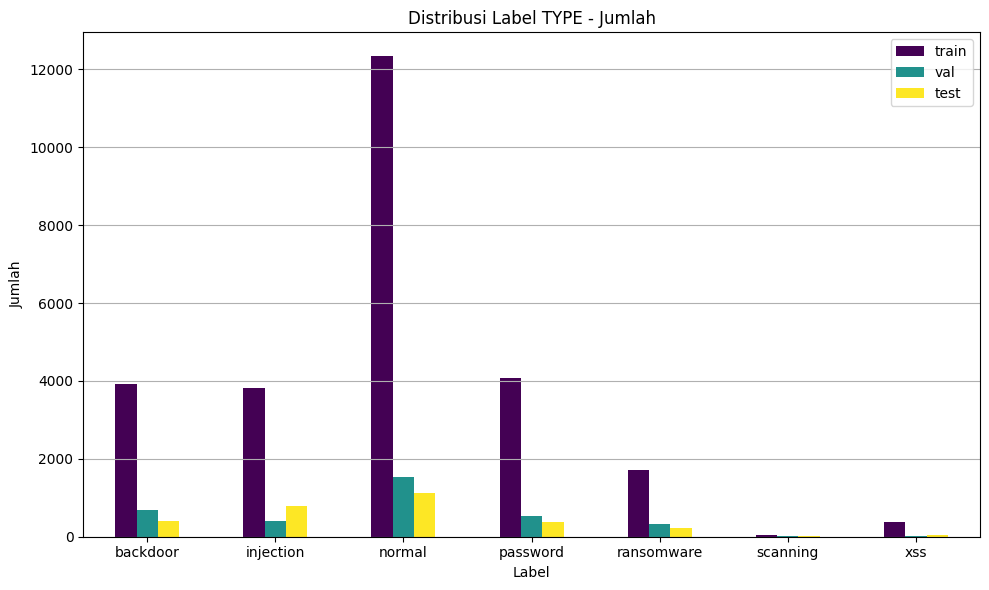

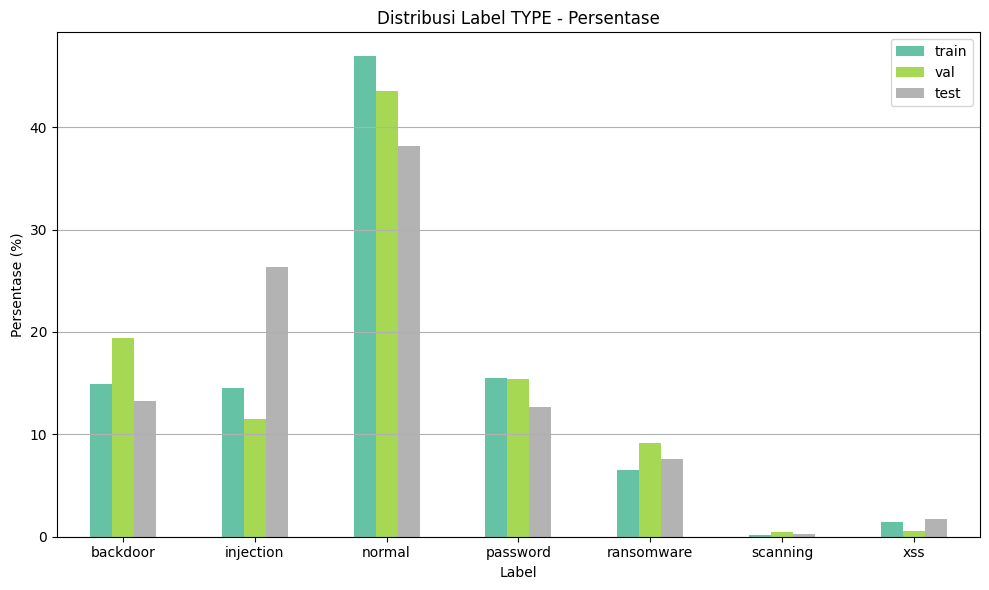

In [13]:
show_label_distribution(y_train_best, y_val_best, y_test_best, label_name='type')

In [14]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Handle any remaining missing values with SimpleImputer
imputer = SimpleImputer(strategy='median')
# X_imputed_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# X_imputed_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
# X_imputed_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# print(f"Features shape train after imputation: {X_imputed_train.shape}")
# print(f"Features shape val after imputation: {X_imputed_val.shape}")
# print(f"Features shape test after imputation: {X_imputed_test.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_best)
X_val_scaled = scaler.transform(X_val_best)
X_test_scaled = scaler.transform(X_test_best)

print("Data scaling completed!")
print(f"Scaled features train shape: {X_train_scaled.shape}")
print(f"Scaled features val shape: {X_val_scaled.shape}")
print(f"Scaled features test shape: {X_test_scaled.shape}")



# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_best)
y_val_encoded = le.transform(y_val_best)
y_test_encoded = le.transform(y_test_best)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(le, f)

print(f"Target classes: {le.classes_}")
print(f"Target train shape: {y_train_encoded.shape}")
print(f"Target val shape: {y_val_encoded.shape}")
print(f"Target test shape: {y_test_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Data scaling completed!
Scaled features train shape: (26281, 27)
Scaled features val shape: (3537, 27)
Scaled features test shape: (2956, 27)
Imputer saved to artifacts/imputer.pkl
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'injection' 'normal' 'password' 'ransomware' 'scanning' 'xss']
Target train shape: (26281,)
Target val shape: (3537,)
Target test shape: (2956,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [15]:
y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

In [16]:
print(X_train_scaled.shape)
print('\n',X_train_scaled[:5])
print('\n',X_val_scaled.shape)
print('\n',X_val_scaled[:5])
print('\n',X_test_scaled.shape)
print('\n',X_test_scaled[:5])
print('\n',y_train_encoded.shape)
print('\n',y_train_encoded[:10])
print('\n',y_val_encoded.shape)
print('\n',y_val_encoded[:10])
print('\n',y_test_encoded.shape)
print('\n',y_test_encoded[:10])
print('\n',y_train_cat.shape)
print('\n',y_train_cat[:10])
print('\n',y_val_cat.shape)
print('\n',y_val_cat[:10])
print('\n',y_test_cat.shape)
print('\n',y_test_cat[:10])

(26281, 27)

 [[3.91929217e-01 0.00000000e+00 5.21739130e-01 7.28813559e-01
  5.59322034e-01 1.00000000e+00 1.00000000e+00 5.08666190e-01
  0.00000000e+00 1.09261996e-02 3.96044155e-01 0.00000000e+00
  3.97283148e-01 0.00000000e+00 0.00000000e+00 4.97698975e-01
  4.95380139e-01 5.07315314e-01 4.73983266e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.86674989e-01]
 [5.99512866e-01 1.00000000e+00 5.21739130e-01 7.28813559e-01
  5.59322034e-01 1.00000000e+00 1.00000000e+00 5.08666190e-01
  0.00000000e+00 1.09261996e-02 3.96044155e-01 0.00000000e+00
  5.22637510e-01 3.08411116e-01 2.07583649e-01 6.01968455e-01
  6.01515952e-01 5.64785159e-01 6.05767930e-01 0.00000000e+00
  1.00000000e+00 9.21098687e-06 5.00000000e-01 0.00000000e+00
  3.01029996e-01 8.86683406e-01 6.02240826e-01]
 [1.26512024e-01 1.00000000e+00 5.21739130e-01 7.28813559e-01
  5.76271186e-01 1.00000000e+00 1.00000000e+00 5.08666190e-01
  0.00000000e+00 1.092

In [17]:
# ================================
# SELEKSI FITUR GA
# ================================

# ===========================
# === PARAMETER DAN INPUT ===
# ===========================
POP_SIZE = 20
N_GENERATIONS = 10
MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 3
FEATURE_COUNT = X_train_scaled.shape[1]
N_CLASSES = y_train_cat.shape[1]

# =============================
# === MODEL LSTM SEDERHANA ===
# =============================
def create_lstm_model(input_shape, n_classes):
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# =============================
# === FUNGSI FITNESS GA ===
# =============================
def fitness(individual):
    if sum(individual) == 0:
        return 0.0,

    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    
    # Ambil subset fitur berdasarkan indeks aktif
    X_train_sub = X_train_scaled[:, selected_features]
    X_val_sub   = X_val_scaled[:, selected_features]

    # Reshape untuk LSTM: (samples, timesteps=1, features)
    X_train_sub = X_train_sub.reshape((X_train_sub.shape[0], 1, X_train_sub.shape[1]))
    X_val_sub   = X_val_sub.reshape((X_val_sub.shape[0], 1, X_val_sub.shape[1]))

    # Buat dan latih model LSTM
    model = create_lstm_model(input_shape=(1, len(selected_features)), n_classes=N_CLASSES)
    model.fit(X_train_sub, y_train_cat, epochs=3, batch_size=64, verbose=0)

    # Evaluasi akurasi
    y_pred = np.argmax(model.predict(X_val_sub, verbose=0), axis=1)
    y_true = np.argmax(y_val_cat, axis=1)
    acc = accuracy_score(y_true, y_pred)

    return acc,

# =============================
# === TOOLS UNTUK GA ===
# =============================
def init_population():
    return [np.random.randint(0, 2, FEATURE_COUNT).tolist() for _ in range(POP_SIZE)]

def tournament_selection(pop, fitnesses):
    selected = random.sample(list(zip(pop, fitnesses)), TOURNAMENT_SIZE)
    selected = sorted(selected, key=lambda x: x[1][0], reverse=True)
    return selected[0][0]

def crossover(parent1, parent2):
    point = random.randint(1, FEATURE_COUNT - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual):
    for i in range(FEATURE_COUNT):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]

# =============================
# === MAIN LOOP GA ===
# =============================
population = init_population()
fitnesses = [fitness(ind) for ind in population]

for gen in range(N_GENERATIONS):
    print(f'\nGeneration {gen + 1}/{N_GENERATIONS}')
    
    accs = [fit[0] for fit in fitnesses]
    print(f' Best fitness: {max(accs):.4f} | Avg fitness: {np.mean(accs):.4f}')

    new_population = []
    while len(new_population) < POP_SIZE:
        parent1 = tournament_selection(population, fitnesses)
        parent2 = tournament_selection(population, fitnesses)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1)
        mutate(child2)
        new_population.extend([child1, child2])

    # Evaluasi populasi baru
    population = new_population[:POP_SIZE]
    fitnesses = [fitness(ind) for ind in population]

# =============================
# === HASIL AKHIR SELEKSI ===
# =============================
accs = [fit[0] for fit in fitnesses]
best_idx = np.argmax(accs)
best_individual = population[best_idx]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

print("\n=== HASIL SELEKSI FITUR GA ===")
print("Indeks Fitur Terpilih:", selected_features)
print("Jumlah Fitur Terpilih:", len(selected_features))
print("Best Fitness (Accuracy): {:.4f}".format(accs[best_idx]))


Generation 1/10
 Best fitness: 0.9717 | Avg fitness: 0.7916

Generation 2/10
 Best fitness: 0.9703 | Avg fitness: 0.8884

Generation 3/10
 Best fitness: 0.9794 | Avg fitness: 0.9299

Generation 4/10
 Best fitness: 0.9805 | Avg fitness: 0.9694

Generation 5/10
 Best fitness: 0.9805 | Avg fitness: 0.9257

Generation 6/10
 Best fitness: 0.9816 | Avg fitness: 0.9695

Generation 7/10
 Best fitness: 0.9808 | Avg fitness: 0.9697

Generation 8/10
 Best fitness: 0.9811 | Avg fitness: 0.9471

Generation 9/10
 Best fitness: 0.9811 | Avg fitness: 0.9648

Generation 10/10
 Best fitness: 0.9805 | Avg fitness: 0.9745

=== HASIL SELEKSI FITUR GA ===
Indeks Fitur Terpilih: [2, 3, 4, 5, 6, 8, 9, 10, 13, 15, 16, 17, 20, 22, 24, 25, 26]
Jumlah Fitur Terpilih: 17
Best Fitness (Accuracy): 0.9805


In [18]:
feature_names = X_all.columns.tolist()

selected_feature_names = [feature_names[i] for i in selected_features]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'hour_cos', 'min_sin', 'min_cos', 'temp_roll_std', 'temp_diff', 'temp_velocity', 'temp_acceleration', 'thermostat_change', 'on_state_percentage', 'temp_entropy', 'temp_state_interaction', 'velocity_state_interaction']


In [19]:
X_train_selected = pd.DataFrame(X_train_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_train_selected.shape)
print(X_train_selected.info())
print(X_train_selected.head())

(26281, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26281 entries, 0 to 26280
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hour                        26281 non-null  float64
 1   minute                      26281 non-null  float64
 2   second                      26281 non-null  float64
 3   day_of_week                 26281 non-null  float64
 4   is_weekend                  26281 non-null  float64
 5   hour_cos                    26281 non-null  float64
 6   min_sin                     26281 non-null  float64
 7   min_cos                     26281 non-null  float64
 8   temp_roll_std               26281 non-null  float64
 9   temp_diff                   26281 non-null  float64
 10  temp_velocity               26281 non-null  float64
 11  temp_acceleration           26281 non-null  float64
 12  thermostat_change           26281 non-null  float64
 13  on_state_percentage

In [20]:
X_val_selected = pd.DataFrame(X_val_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_val_selected.shape)
print(X_val_selected.info())

(3537, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hour                        3537 non-null   float64
 1   minute                      3537 non-null   float64
 2   second                      3537 non-null   float64
 3   day_of_week                 3537 non-null   float64
 4   is_weekend                  3537 non-null   float64
 5   hour_cos                    3537 non-null   float64
 6   min_sin                     3537 non-null   float64
 7   min_cos                     3537 non-null   float64
 8   temp_roll_std               3537 non-null   float64
 9   temp_diff                   3537 non-null   float64
 10  temp_velocity               3537 non-null   float64
 11  temp_acceleration           3537 non-null   float64
 12  thermostat_change           3537 non-null   float64
 13  on_state_percentage   

In [21]:
X_test_selected = pd.DataFrame(X_test_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_test_selected.shape)
print(X_test_selected.info())

(2956, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hour                        2956 non-null   float64
 1   minute                      2956 non-null   float64
 2   second                      2956 non-null   float64
 3   day_of_week                 2956 non-null   float64
 4   is_weekend                  2956 non-null   float64
 5   hour_cos                    2956 non-null   float64
 6   min_sin                     2956 non-null   float64
 7   min_cos                     2956 non-null   float64
 8   temp_roll_std               2956 non-null   float64
 9   temp_diff                   2956 non-null   float64
 10  temp_velocity               2956 non-null   float64
 11  temp_acceleration           2956 non-null   float64
 12  thermostat_change           2956 non-null   float64
 13  on_state_percentage   


CORRELATION ANALYSIS


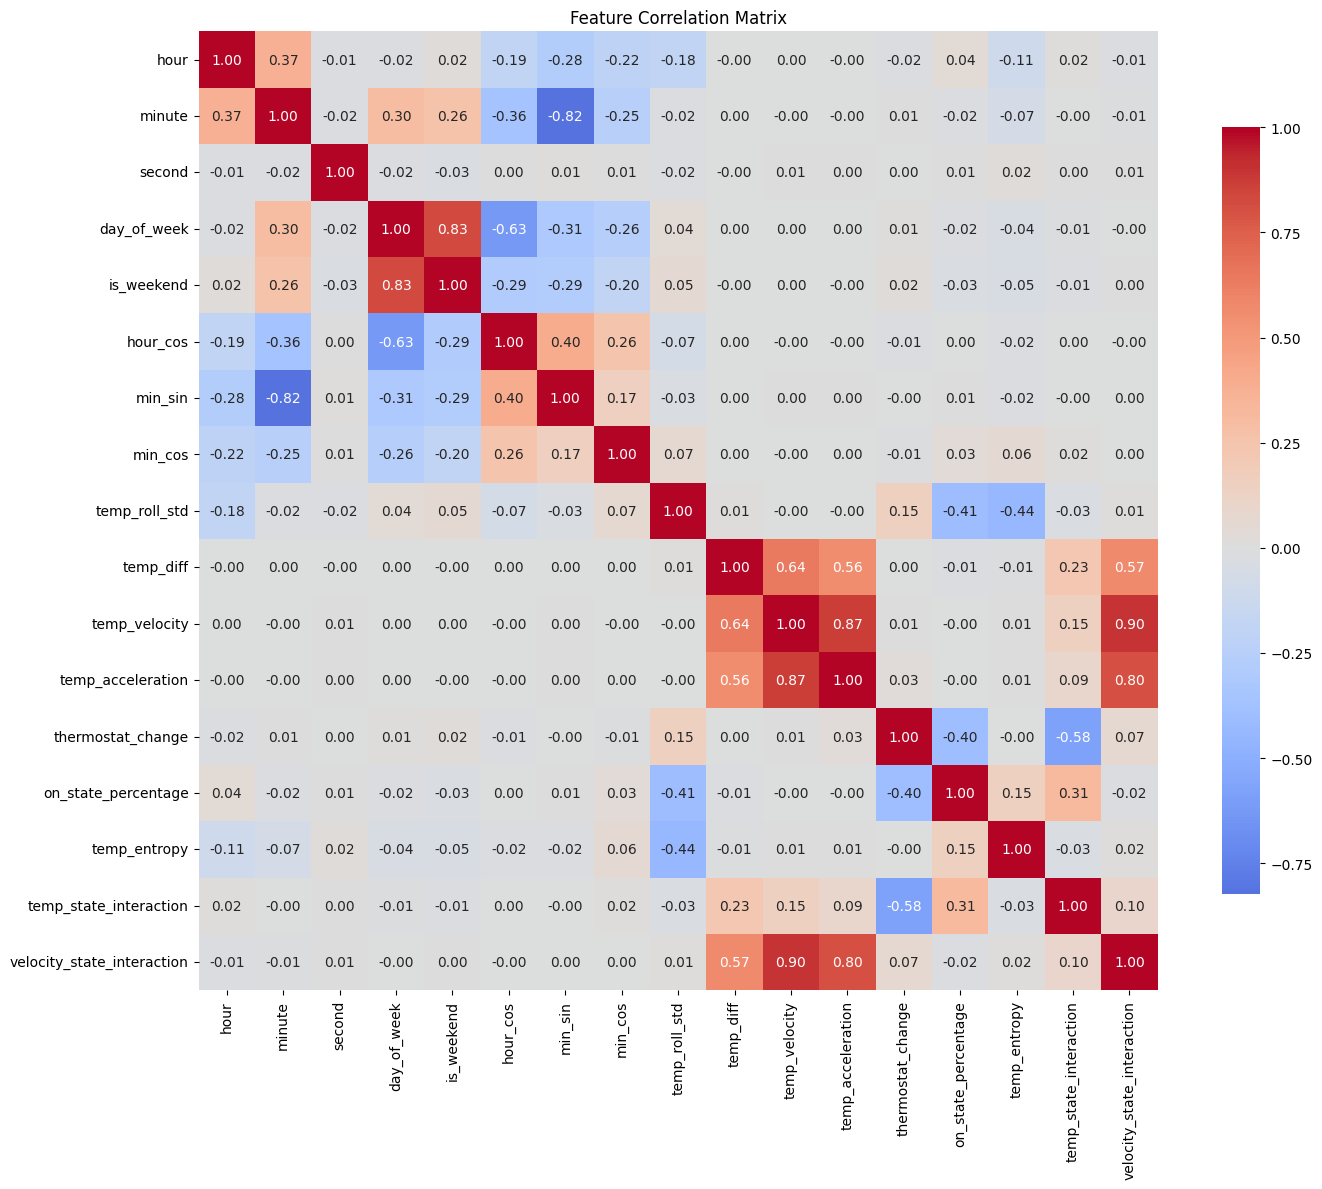

In [22]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_train_selected.corr()

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

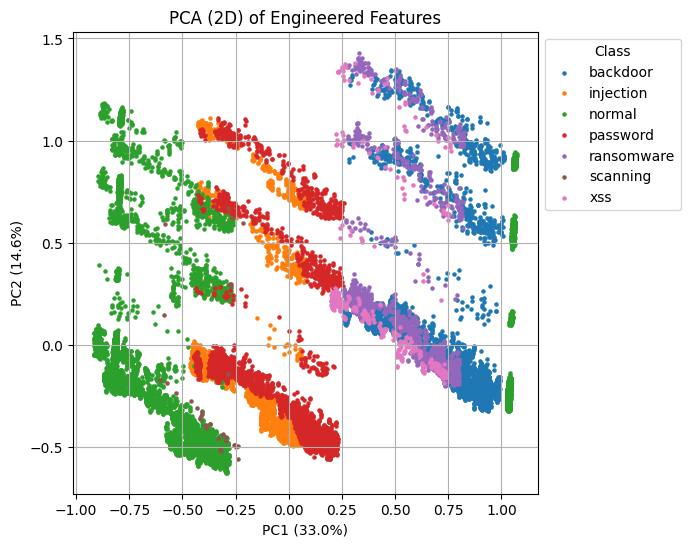

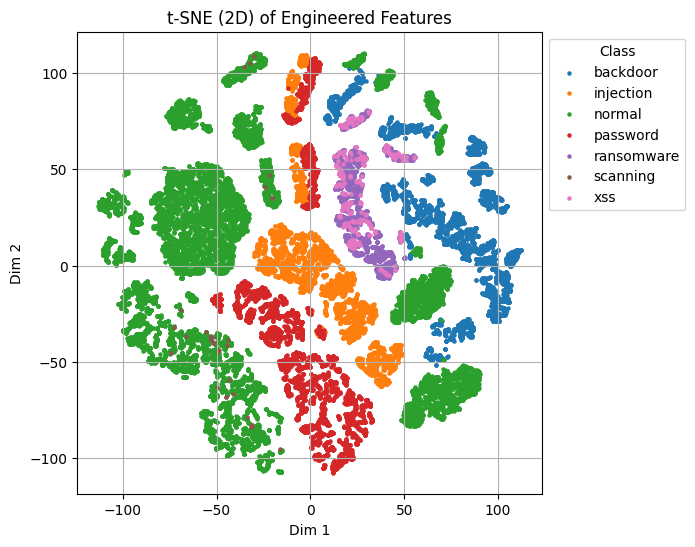

In [23]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_selected)

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4) t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_train_selected)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [24]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_train_selected)

# 2) Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y_train_best
})

# 3) Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# 4) Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_train_selected)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y_train_best

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [25]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_train_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_train_selected, y_train_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_train_selected)
df_final['type'] = np.array(y_train_encoded)

csv_path = os.path.join(artifacts_dir, 'data_train_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [26]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_val_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_val_selected, y_val_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_val_selected)
df_final['type'] = np.array(y_val_encoded)

csv_path = os.path.join(artifacts_dir, 'data_val_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [27]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_test_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_test_selected, y_test_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_test_selected)
df_final['type'] = np.array(y_test_encoded)

csv_path = os.path.join(artifacts_dir, 'data_test_preprocessing.csv')
df_final.to_csv(csv_path, index=False)